In [4]:
#future is the missing compatibility layer between Python 2 and Python 3. 
#It allows you to use a single, clean Python 3.x-compatible codebase to 
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [5]:
#encoding
import codecs
#finds all pathnames matching the a pattern
import glob
#log events for libraries
import logging 
#multiprocessing
import multiprocessing 
import os
import pprint
#regular expression 
import re

In [6]:
#natural language toolkit
import nltk
#word 2 vec
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#parse dataset
import pandas as pd
#visualization
import seaborn as sns

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
#stopwords like the at a an, unnecesasry
#tokenization into sentences, punkt 
#http://www.nltk.org/
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/shash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/shash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
#read nvd files
NVD_files= sorted(glob.glob("*.txt"))
print("Found books:")
NVD_files



Found books:


['nvd_corpus.txt']

In [9]:
#step 1 process data

#initialize rawunicode , we'll add all text to this one bigass file in memory
corpus_raw = u""
#for each book, read it, open it un utf 8 format, 
#add it to the raw corpus
for NVD_file in NVD_files:
    print("Reading '{0}'...".format(NVD_file))
    with codecs.open(NVD_file, "r", "utf-8") as NVD_file:
        corpus_raw += NVD_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'nvd_corpus.txt'...
Corpus is now 9215435 characters long



In [10]:
#tokenizastion! saved the trained model here
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
#tokenize into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into list of words
#remove unecessary characters, split into words, no hyhens and shit
#split into words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#for each sentece, sentences where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
#print an example
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

O
" O

CVE-2011-1286
Google B-vendor
V8 O
, O
as O
used O
in O
Google B-vendor
Chrome B-application
before B-version
10.0.648.127 I-version
, O
allows B-relevant_term
remote B-relevant_term
attackers I-relevant_term
to O
cause O
a O
denial B-relevant_term
of I-relevant_term
service I-relevant_term
or O
possibly O
have O
unspecified O
other O
impact O
via O
unknown O
vectors O
that O
trigger O
incorrect O
access B-relevant_term
to O
memory B-relevant_term
.
[u'O', u'O', u'CVE', u'Google', u'B', u'vendor', u'V', u'O', u'O', u'as', u'O', u'used', u'O', u'in', u'O', u'Google', u'B', u'vendor', u'Chrome', u'B', u'application', u'before', u'B', u'version', u'I', u'version', u'O', u'allows', u'B', u'relevant', u'term', u'remote', u'B', u'relevant', u'term', u'attackers', u'I', u'relevant', u'term', u'to', u'O', u'cause', u'O', u'a', u'O', u'denial', u'B', u'relevant', u'term', u'of', u'I', u'relevant', u'term', u'service', u'I', u'relevant', u'term', u'or', u'O', u'possibly', u'O', u'have', u

In [15]:
#count tokens, each one being a sentence
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,656,837 tokens


In [16]:
#step 2 build our model, another one is Glove
#define hyperparameters

# Dimensionality of the resulting word vectors.
#more dimensions mean more traiig them, but more generalized
num_features = 300

#
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [17]:
NVD2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
NVD2vec.build_vocab(sentences)

In [19]:
print("Word2Vec vocabulary length:", len(NVD2vec.vocab))

Word2Vec vocabulary length: 7325


In [20]:
#train model on sentneces
NVD2vec.train(sentences)

3067042

In [21]:
#save model
if not os.path.exists("NVDtrained"):
    os.makedirs("NVDtrained")

In [22]:
NVD2vec.save(os.path.join("NVDtrained", "NVD2vec.w2v"))

In [9]:
#load model
NVD2vec_load = w2v.Word2Vec.load(os.path.join("NVDtrained", "NVD2vec.w2v"))

In [10]:
#squash dimensionality to 2
#https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [11]:
#put it all into a gaint matrix
all_word_vectors_matrix=NVD2vec_load.syn0

In [12]:
#train t sne
all_word_vectors_matrix_2d=tsne.fit_transform(all_word_vectors_matrix)

In [13]:
#plot point in 2d space
points=pd.DataFrame(
[
    (word,coords[0],coords[1])
    for word, coords in [
        (word,all_word_vectors_matrix_2d[NVD2vec_load.vocab[word].index])
        for word in NVD2vec_load.vocab
                        ]
],
    columns=["word","x","y"]
)

In [14]:
points.head(10)

,word,x,y
0,Mailman,-0.547525,-9.202336
1,prefix,-5.666077,5.312676
2,Foundation,-2.911248,-2.756642
3,otrl,-6.313117,0.990288
4,granting,-6.724722,5.796236
5,SPR,-9.884742,-7.204139
6,AuthIP,6.591543,0.597170
7,SPL,-1.313544,0.760273
8,SPA,-4.608094,-1.195634
9,virtio,4.885207,3.840565


In [15]:
#plot
sns.set_context("poster")

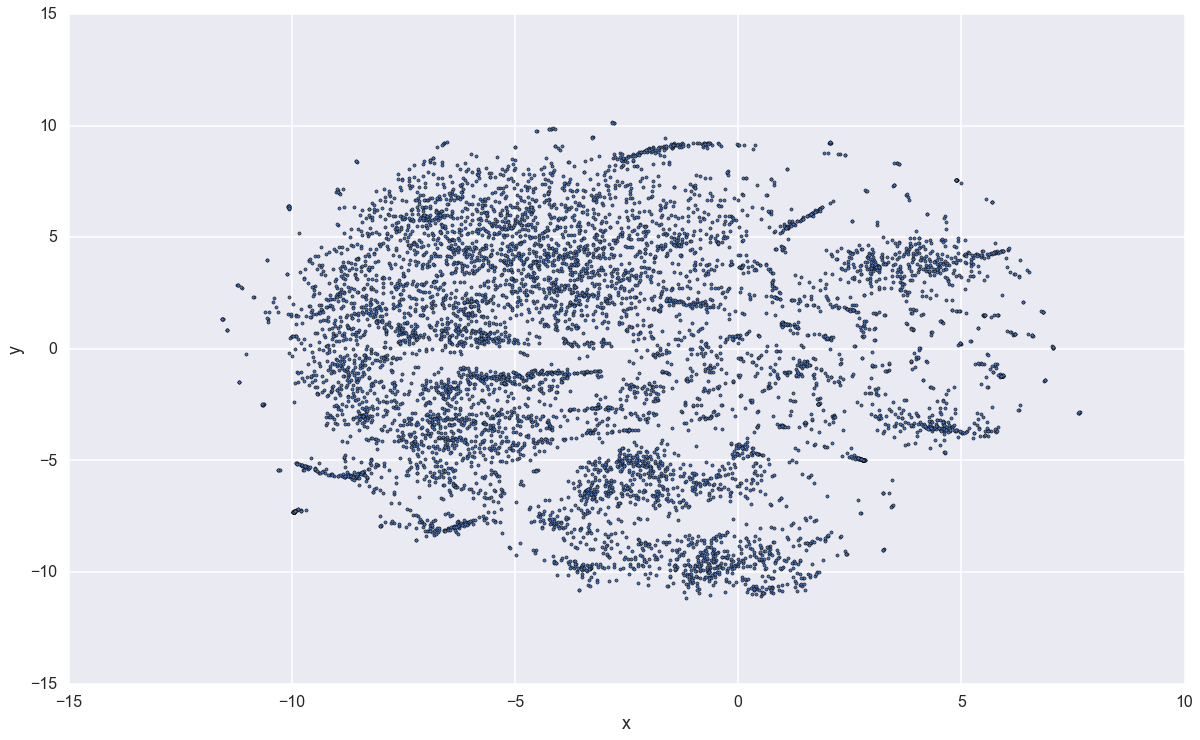

In [16]:
points.plot.scatter("x","y",s=10,figsize=(20,12))

In [17]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

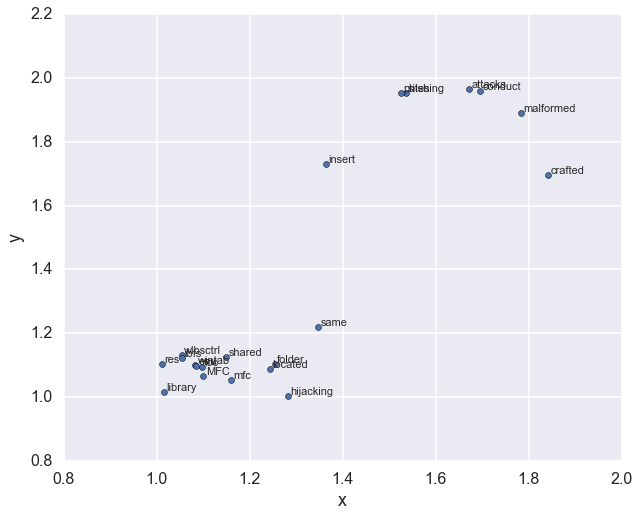

In [26]:
plot_region(x_bounds=(1, 2), y_bounds=(1, 2))

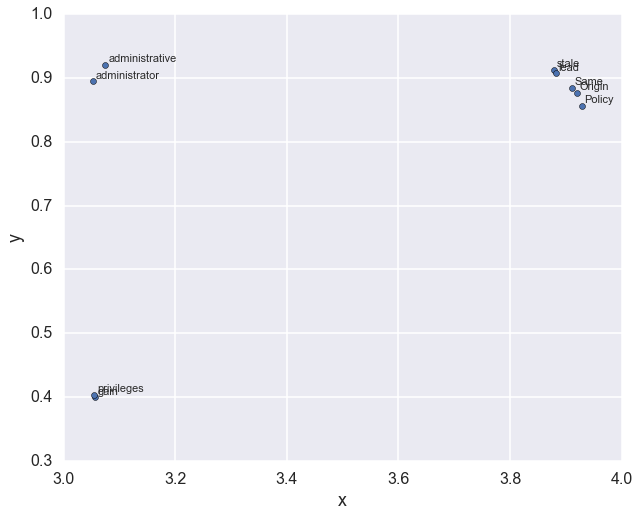

In [35]:
plot_region(x_bounds=(3, 4), y_bounds=(0, 1))

In [37]:
NVD2vec_load.most_similar("Microsoft")

[(u'XP', 0.6901383996009827),
 (u'SharePoint', 0.650600254535675),
 (u'GDI', 0.6411085724830627),
 (u'Shell', 0.6382219791412354),
 (u'DirectShow', 0.6279549598693848),
 (u'DirectX', 0.6273525357246399),
 (u'Pinyin', 0.6202549934387207),
 (u'VBE', 0.6180347204208374),
 (u'Packager', 0.6121503710746765),
 (u'Ancillary', 0.6099170446395874)]

In [38]:
NVD2vec_load.most_similar("Windows")

[(u'os', 0.7887817025184631),
 (u'Vista', 0.7597812414169312),
 (u'XP', 0.7491596937179565),
 (u'WMP', 0.7138122320175171),
 (u'Release', 0.7055044174194336),
 (u'Quartz', 0.6784756779670715),
 (u'iChat', 0.6748684644699097),
 (u'libsecurity', 0.6657674312591553),
 (u'InfoPath', 0.6638948917388916),
 (u'hotfix', 0.6631326079368591)]

In [43]:
NVD2vec_load.most_similar("Vulnerability")

[(u'Corruption', 0.8263347148895264),
 (u'Overflow', 0.7540878653526306),
 (u'Code', 0.7284419536590576),
 (u'Parsing', 0.7264837026596069),
 (u'Execution', 0.72187340259552),
 (u'Pointer', 0.7188808917999268),
 (u'Win', 0.7164008617401123),
 (u'Null', 0.7132523059844971),
 (u'After', 0.7092171311378479),
 (u'Handling', 0.6932014226913452)]